<a href="https://colab.research.google.com/github/dwtkse33/ml_GoogleColab/blob/master/Tensorflow%EC%99%80_RNN_%EB%84%A4%EC%9D%B4%EB%B2%84%EC%98%81%ED%99%94%ED%8F%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
tensorflow_version 2.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 코렙 mecab 설치 
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
     |████████████████████████████████| 19.4MB 1.7MB/s 
     |████████████████████████████████| 3.8MB 37.2MB/s 
     |████████████████████████████████| 92kB 10.0MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing ins

1. 네이버 영화리뷰 데이터 읽기 
2. 데이터 정체(이모티콘, 영문, 숫자, ...삭제) 
3. 토큰화(mecab) - 불용처리, 1글자 제거. 
4. RNN 모델을 학습 시킬 수 있는 형태로 변경 
5. RNN 학습 
6. 학습된 모델로 test 데이터 예측 

In [10]:
import numpy as np 
import pandas as pd

In [11]:
from google.colab import drive # import drive from google colab
ROOT = '/content/drive' #default location from the drive
drive.mount(ROOT) #print content of ROOT(Optional)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
%pwd

'/content'

In [13]:
%ls

drive/  sample_data/


In [14]:
%cd drive/'My Drive'/'빅데이터 교육 과정/31일차'

/content/drive/My Drive/빅데이터 교육 과정/31일차


## 1. 영화리뷰 데이터 읽기

In [17]:
import pandas as pd 
from pandas.io import gbq

# import sample_submission file
reviews = pd.DataFrame(pd.read_csv('ratings_train.txt', sep= '\t', quoting=3))
reviews

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


## 2) 데이터 정제 

In [24]:
reviews_2 = reviews.dropna()
reviews_2 = reviews_2.reset_index(drop=True)
reviews_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149995 entries, 0 to 149994
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [25]:
review_4 = reviews_2[:10000]

In [29]:
import re 
# '한글'을 제외한 다른 문자 모두 제거, 숫자/영문/...기호 등 삭제
remove_except_ko = re.compile(r"[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]") # ^는 ~을 제외한이라는 뜻
def preprocess(text):
    text = re.sub(remove_except_ko,' ',text).strip()
    return text

review_4['document'] = review_4['document'].map(lambda x : preprocess(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
from konlpy.tag import Mecab

In [32]:
mecab = Mecab()

mecab_tokens = []
for i in range(len(review_4)) : 
    mecab_tokens.append(mecab.nouns(review_4["document"][i])) 
mecab_tokens
# mecab.nouns(review_4["document"]컬럼의 [i]번째 row의 문장을 mecab_tokens라는 리스트에 하나씩 넣어줌)

[['짜증', '나', '목소리'],
 ['포스터', '초딩', '영화', '줄', '오버', '연기'],
 [],
 ['교도소', '이야기', '재미', '평점', '조정'],
 ['사이몬페그', '익살', '연기', '영화', '스파이더맨', '커스틴', '던스트'],
 ['걸음마', '세', '초등', '학교', '학년', '살용', '영화', '개'],
 ['원작', '긴장감'],
 ['반개',
  '욕',
  '이응경',
  '길용우',
  '연기',
  '생활',
  '년',
  '발',
  '그것',
  '납치',
  '감금',
  '반복',
  '반복',
  '드라마',
  '가족',
  '연기',
  '사람'],
 ['액션', '재미', '영화'],
 ['평점', '건데', '만', '헐리우드'],
 ['짱'],
 ['때', '년', '대', '향수', '자극', '허진호', '감성', '절제', '멜로', '달인'],
 ['횡단', '보도', '때', '뻔', '이범수', '연기'],
 ['신문', '기사', '그', '사람', '것'],
 ['취향', '존중', '내생', '극장', '영화', '중', '잼', '감동', '스토리', '감동', '어거지'],
 ['ㄱ', '냥', '긴장', '밋'],
 ['사람', '게', '바스코', '이기면', '락스', '코', '바비', '아이돌', '안달', '것'],
 ['굿바이', '레닌', '표절', '것', '이해', '뒤'],
 ['이건', '깨알', '캐스팅', '내용', '구성', '깨알', '드'],
 ['약탈자', '변명', '저놈', '놈'],
 ['나름', '뜻', '듯', '학생', '선생', '영화'],
 ['건', '가능'],
 ['음식',
  '영화',
  '바베트',
  '만찬',
  '차이',
  '남',
  '바베트',
  '만찬',
  '이야기',
  '음식',
  '재미',
  '이건',
  '게',
  '음식',
  '핀란드',
  '풍경',
  '구경',
  

## 3) 품사부착(PoS Tagging)


In [68]:
tmp = [] 
for i in range(len(review_4)):
  tmp.append(mecab.pos(review_4["document"][i]))
tmp
# mecab_tag = [] 
# for token in mecab_tokens: 
#     mecab_tag += mecab.pos(token)
# print(mecab_tag)

[[('아', 'IC'),
  ('더', 'MAG'),
  ('빙', 'MAG'),
  ('진짜', 'MAG'),
  ('짜증', 'NNG'),
  ('나', 'NP'),
  ('네요', 'VCP+EC'),
  ('목소리', 'NNG')],
 [('흠', 'IC'),
  ('포스터', 'NNP'),
  ('보고', 'JKB'),
  ('초딩', 'NNG'),
  ('영화', 'NNG'),
  ('줄', 'NNG'),
  ('오버', 'NNG'),
  ('연기', 'NNG'),
  ('조차', 'JX'),
  ('가볍', 'VA'),
  ('지', 'EC'),
  ('않', 'VX'),
  ('구나', 'EC')],
 [('너무', 'MAG'), ('재', 'XPN'), ('밓었다그래서보는것을추천한다', 'UNKNOWN')],
 [('교도소', 'NNG'),
  ('이야기', 'NNG'),
  ('구먼', 'VCP+EF'),
  ('솔직히', 'MAG'),
  ('재미', 'NNG'),
  ('는', 'JX'),
  ('없', 'VA'),
  ('다', 'EC'),
  ('평점', 'NNG'),
  ('조정', 'NNG')],
 [('사이몬페그', 'NNP'),
  ('의', 'JKG'),
  ('익살', 'NNG'),
  ('스런', 'XSA+ETM'),
  ('연기', 'NNG'),
  ('가', 'JKS'),
  ('돋보였', 'VV+EP'),
  ('던', 'ETM'),
  ('영화', 'NNG'),
  ('스파이더맨', 'NNP'),
  ('에서', 'JKB'),
  ('늙', 'VV'),
  ('어', 'EC'),
  ('보이', 'VV'),
  ('기', 'ETN'),
  ('만', 'JX'),
  ('했', 'VV+EP'),
  ('던', 'ETM'),
  ('커스틴', 'NNP'),
  ('던스트', 'NNP'),
  ('가', 'JKS'),
  ('너무나', 'MAG'),
  ('도', 'JX'),
  ('이뻐', 'VA+EC'),
  ('보였

In [39]:
stop_word = ['께서','에서','이다','에게','으로','이랑','까지','부터','하다', '했다']
stopPos = ['JKS','JKC','JKG','JKO','JKB','JKV','JKQ','JC','JX',
           'SF','SE','SS','SP','SSO','SSC','SC','SY','SH','SL','SN',
           'MM','MAG','MAJ']
def token_mecab(text):
    text = mecab.pos(text)
    text = [i for i in text if len(i[0])>1]
    text = [i for i in text if i[0] not in stop_word]
    text = [i[0] for i in text if i[1] not in stopPos]
    return text

In [43]:
token_mecab

<function __main__.token_mecab>

In [45]:
review_4.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [49]:
# 토큰화 + 토큰리스트 생성 
def make_tokens(review_4):
    review_4['tokens'] = ''
    tokens_list=[]
    for i, row in review_4.iterrows():
        if i%10000==0:
            print(i,'/',len(review_4))
        token = token_mecab(review_4['document'][i])
        review_4['tokens'][i] = ' '.join(token)
    return review_4

review_4 = make_tokens(review_4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

0 / 10000


In [51]:
review_4.head()

,id,document,label,tokens
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,짜증 네요 목소리
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1,포스터 초딩 영화 오버 연기 가볍 구나
2,10265843,너무재밓었다그래서보는것을추천한다,0,밓었다그래서보는것을추천한다
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0,교도소 이야기 구먼 재미 평점 조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이몬페그 익살 스런 연기 돋보였 영화 스파이더맨 보이 커스틴 던스트 이뻐 보였


In [52]:
X_train = list(review_4['tokens'])
Y_train = list(review_4['label'])

In [55]:
# 위의 코드를 활용하여 tokens를 다시 토큰화하고? 각각의 토큰을 숫자로 변경하였습니다.
from keras.preprocessing.text import Tokenizer 
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train) 
sequences = tokenizer.texts_to_sequences(X_train)

In [57]:
word_index = tokenizer.word_index
word_index

{'영화': 1,
 '는데': 2,
 '재밌': 3,
 '지만': 4,
 '네요': 5,
 'ㅋㅋ': 6,
 '연기': 7,
 '최고': 8,
 '평점': 9,
 '어요': 10,
 '스토리': 11,
 '습니다': 12,
 '사람': 13,
 '드라마': 14,
 '아니': 15,
 '감동': 16,
 '감독': 17,
 '생각': 18,
 '배우': 19,
 '만들': 20,
 'ㅋㅋㅋ': 21,
 '내용': 22,
 '시간': 23,
 '지루': 24,
 '재미': 25,
 '재미없': 26,
 '재미있': 27,
 '면서': 28,
 '사랑': 29,
 '작품': 30,
 '나오': 31,
 '쓰레기': 32,
 '해서': 33,
 '하나': 34,
 '라고': 35,
 '이거': 36,
 '액션': 37,
 '이건': 38,
 '라는': 39,
 '정도': 40,
 '다는': 41,
 '마지막': 42,
 '모르': 43,
 '기대': 44,
 '입니다': 45,
 '아깝': 46,
 '최악': 47,
 '장면': 48,
 '이게': 49,
 '이야기': 50,
 '으면': 51,
 '어서': 52,
 '명작': 53,
 '봐도': 54,
 '주인공': 55,
 '인데': 56,
 '다고': 57,
 'ㅠㅠ': 58,
 '는지': 59,
 '연출': 60,
 '다가': 61,
 '우리': 62,
 '이상': 63,
 '느낌': 64,
 '이해': 65,
 '괜찮': 66,
 '한국': 67,
 '합니다': 68,
 '처음': 69,
 '한다': 70,
 '남자': 71,
 '결말': 72,
 '기억': 73,
 'ㅡㅡ': 74,
 '인생': 75,
 '소재': 76,
 '여자': 77,
 '때문': 78,
 '다니': 79,
 '만든': 80,
 '마음': 81,
 '짜증': 82,
 '인간': 83,
 '매력': 84,
 '현실': 85,
 '세요': 86,
 '필요': 87,
 '유치': 88,
 '실망': 89,
 '가슴': 90,
 'ㅎㅎ': 

줄거리의 최대 길이 : 118
줄거리의 평균 길이 : 20.4538


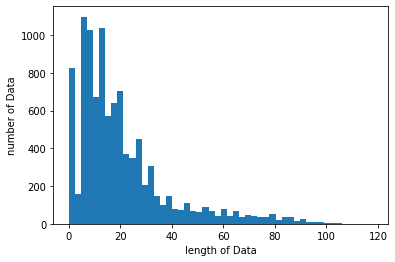

In [62]:
import matplotlib.pyplot as plt

print('줄거리의 최대 길이 : {}'.format(max(len(l) for l in X_train))) 
print('줄거리의 평균 길이 : {}'.format(sum(map(len, X_train)) / len(X_train))) 
plt.hist([len(s) for s in X_train], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

In [63]:
from keras.datasets import reuters 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding 
from keras.preprocessing import sequence 
from keras.utils import np_utils 

max_len = 140 

X_train = pad_sequences(X_train, maxlen=max_len) 
# 패딩이란? 길이를 통일시키는 것. 그래서 the majority의 리뷰길이를 위처럼 시각화, %를 알아봐서 
# 가장 majority 수치에 가까운 size로 training 시켜주는 작업 
Y_train = np_utils.to_categorical(Y_train)

ValueError: ignored

In [ ]:
model3= Sequential